In [183]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_predict, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, confusion_matrix, precision_score, plot_roc_curve, auc

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')
sns.set()

# 1. Importing Data

In [184]:
#Menginput data csv
#Melakukan parse pada data-data tanggal agar terbaca sebagai date
start_up=pd.read_csv('startup data.csv',\
                     parse_dates=['founded_at','first_funding_at','last_funding_at'])

In [186]:
#Preview dataset
start_up.head()

,Unnamed: 0,state_code,latitude,longitude,zip_code,id,city,Unnamed: 6,name,labels,...,object_id,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
0,1005,CA,42.358880,-71.056820,92101,c:6669,San Diego,NaN,Bandsintown,1,...,c:6669,0,1,0,0,0,0,1.0000,0,acquired
1,204,CA,37.238916,-121.973718,95032,c:16283,Los Gatos,NaN,TriCipher,1,...,c:16283,1,0,0,1,1,1,4.7500,1,acquired
2,1001,CA,32.901049,-117.192656,92121,c:65620,San Diego,San Diego CA 92121,Plixi,1,...,c:65620,0,0,1,0,0,0,4.0000,1,acquired
3,738,CA,37.320309,-122.050040,95014,c:42668,Cupertino,Cupertino CA 95014,Solidcore Systems,1,...,c:42668,0,0,0,1,1,1,3.3333,1,acquired
4,1002,CA,37.779281,-122.419236,94105,c:65806,San Francisco,San Francisco CA 94105,Inhale Digital,0,...,c:65806,1,1,0,0,0,0,1.0000,1,closed


# 1.1 Initial Screening

In [187]:
#Melihat jumlah baris dan jumlah kolom
start_up.shape

(923, 49)

In [188]:
#Melihat statistik dari data numeric
start_up.describe()

,Unnamed: 0,latitude,longitude,labels,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,...,is_consulting,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500
count,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,771.000000,771.000000,923.000000,923.000000,...,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000
mean,572.297941,38.517442,-103.539212,0.646804,2.235630,3.931456,3.055353,4.754423,7.710726,2.310943,...,0.003250,0.322860,0.326111,0.254605,0.508126,0.392199,0.232936,0.099675,2.838586,0.809317
std,333.585431,3.741497,22.394167,0.478222,2.510449,2.967910,2.977057,3.212107,7.265776,1.390922,...,0.056949,0.467823,0.469042,0.435875,0.500205,0.488505,0.422931,0.299729,1.874601,0.393052
min,1.000000,25.752358,-122.756956,0.000000,-9.046600,-9.046600,-14.169900,-7.005500,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,283.500000,37.388869,-122.198732,0.000000,0.576700,1.669850,1.000000,2.411000,3.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.500000,1.000000
50%,577.000000,37.779281,-118.374037,1.000000,1.446600,3.528800,2.520500,4.476700,5.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.500000,1.000000
75%,866.500000,40.730646,-77.214731,1.000000,3.575350,5.560250,4.686300,6.753400,10.000000,3.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,3.800000,1.000000
max,1153.000000,59.335232,18.057121,1.000000,21.895900,21.895900,24.684900,24.684900,63.000000,10.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,16.000000,1.000000


In [189]:
#Melihat tipe data dari tiap kolom
start_up.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 923 entries, 0 to 922
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Unnamed: 0                923 non-null    int64         
 1   state_code                923 non-null    object        
 2   latitude                  923 non-null    float64       
 3   longitude                 923 non-null    float64       
 4   zip_code                  923 non-null    object        
 5   id                        923 non-null    object        
 6   city                      923 non-null    object        
 7   Unnamed: 6                430 non-null    object        
 8   name                      923 non-null    object        
 9   labels                    923 non-null    int64         
 10  founded_at                923 non-null    datetime64[ns]
 11  closed_at                 335 non-null    object        
 12  first_funding_at      

In [190]:
#Melihat missing value dari setiap kolom
start_up.isnull().sum()

Unnamed: 0                    0
state_code                    0
latitude                      0
longitude                     0
zip_code                      0
id                            0
city                          0
Unnamed: 6                  493
name                          0
labels                        0
founded_at                    0
closed_at                   588
first_funding_at              0
last_funding_at               0
age_first_funding_year        0
age_last_funding_year         0
age_first_milestone_year    152
age_last_milestone_year     152
relationships                 0
funding_rounds                0
funding_total_usd             0
milestones                    0
state_code.1                  1
is_CA                         0
is_NY                         0
is_MA                         0
is_TX                         0
is_otherstate                 0
category_code                 0
is_software                   0
is_web                        0
is_mobil

In [191]:
#Mengecek duplikasi data
start_up.duplicated().any()

False

In [192]:
#Proporsi status (sebagai variabel keputusan)
start_up['status'].value_counts()

acquired    597
closed      326
Name: status, dtype: int64

# 2. Exploratory Data Analysis

## 2.1 Visualize Numeric Features

In [193]:
to_hist_num=['age_first_funding_year','age_last_funding_year',
             'age_first_milestone_year','age_last_milestone_year',
             'relationships','funding_rounds',
             'milestones','avg_participants']

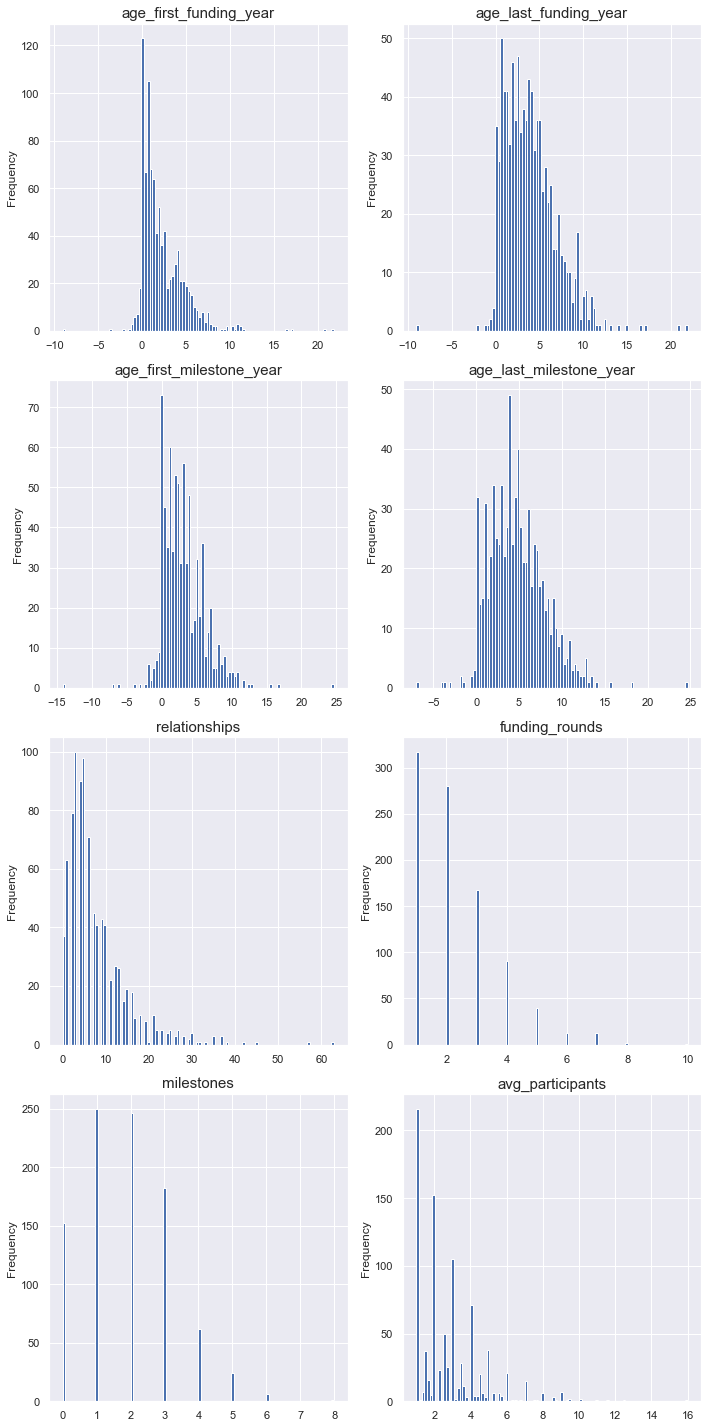

In [194]:
#Membuat histogram dari kolom-kolom terpilih
f, axes = plt.subplots(4, 2, figsize=(10,20))

for ax,col in zip(axes.flatten(), to_hist_num):
    start_up[col].plot(kind='hist', ax=ax, bins=100)
    ax.set_title(col, fontsize=15)
    
f.tight_layout()

## 2.2 Visualize Categorical Features

In [196]:
to_hist_cat=['state_code','category_code']

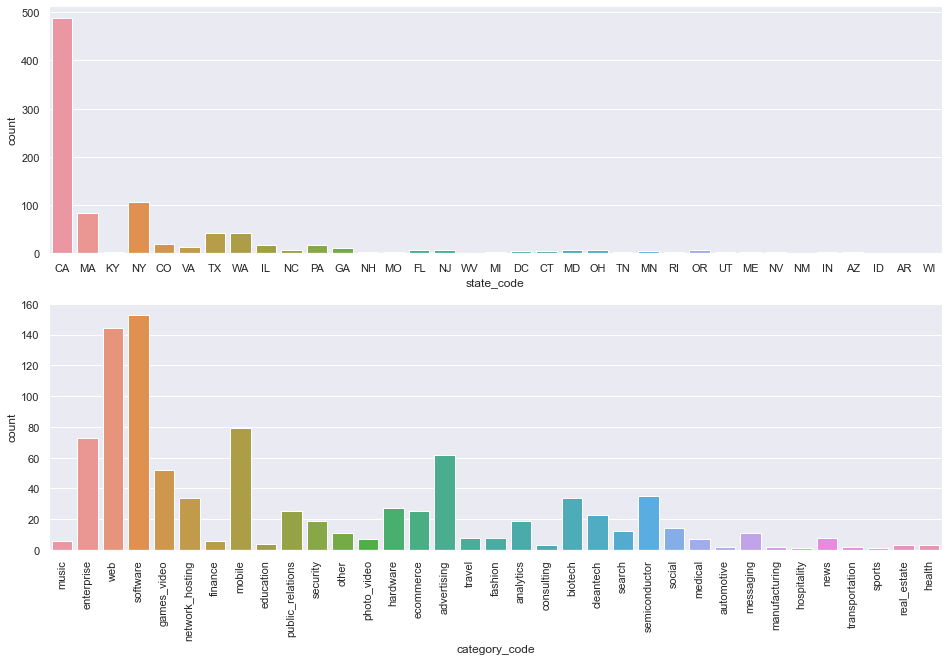

In [197]:
##Membuat histogram dari kolom-kolom terpilih
fig, axs = plt.subplots(2,figsize=(16,10))


for ax,col in zip(fig.axes, to_hist_cat):
    sns.countplot(x=start_up[col], ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    
f.tight_layout()


## 2.3 Distribution of Status on Columns

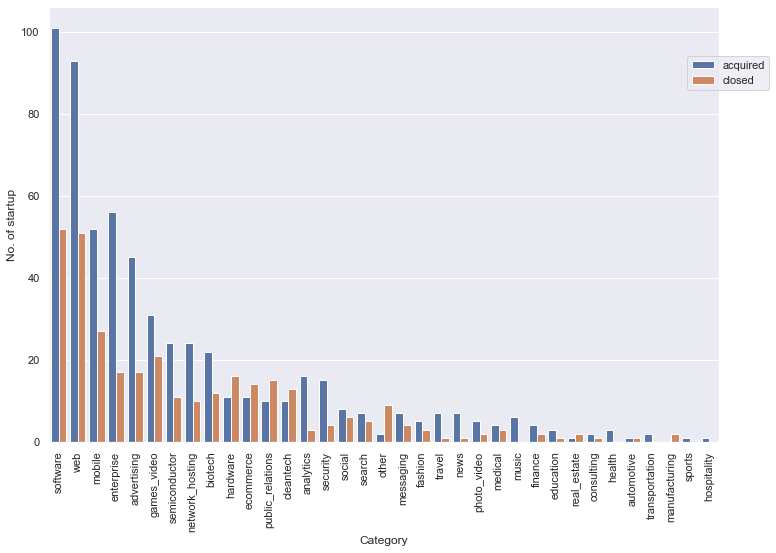

In [198]:
#Membuat distribusi status pada kolom category
fig, ax = plt.subplots(figsize=(12,8))

_ = sns.countplot(x="category_code", hue="status", data=start_up,
              order=start_up.category_code.value_counts().index)

_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
_ = ax.set(xlabel="Category", ylabel="No. of startup")
plt.legend(bbox_to_anchor=(0.945, 0.90))

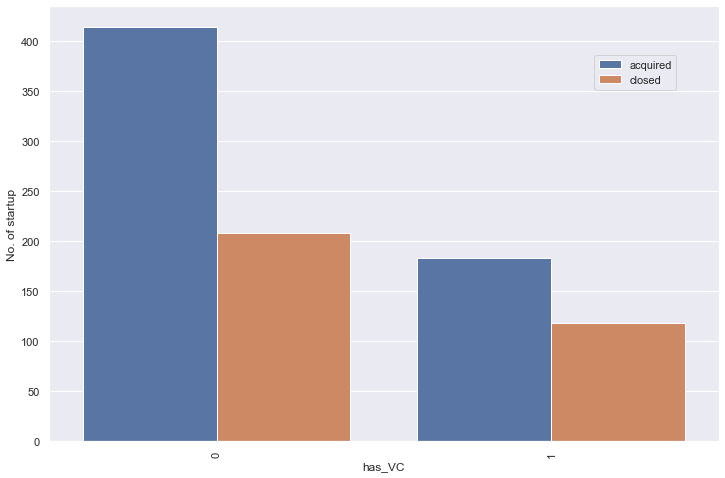

In [199]:
#Membuat distribusi status pada kolom has_VC
fig, ax = plt.subplots(figsize=(12,8))

_ = sns.countplot(x="has_VC", hue="status", data=start_up,
              order=start_up.has_VC.value_counts().index)

_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
_ = ax.set(xlabel="has_VC", ylabel="No. of startup")
plt.legend(bbox_to_anchor=(0.945, 0.90))

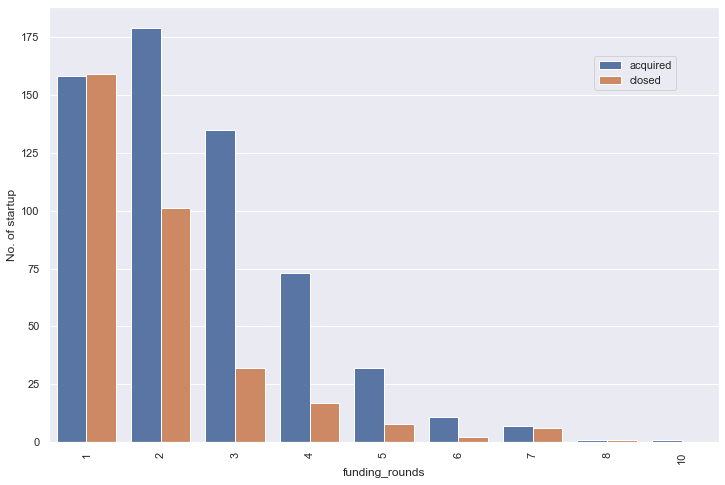

In [200]:
#Membuat distribusi status pada kolom funding_rounds
fig, ax = plt.subplots(figsize=(12,8))

_ = sns.countplot(x="funding_rounds", hue="status", data=start_up,
              order=start_up.funding_rounds.value_counts().index)

_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
_ = ax.set(xlabel="funding_rounds", ylabel="No. of startup")
plt.legend(bbox_to_anchor=(0.945, 0.90))

## 2.4 Proportion of Labels

Text(0.5, 1.0, 'Status Proportion')

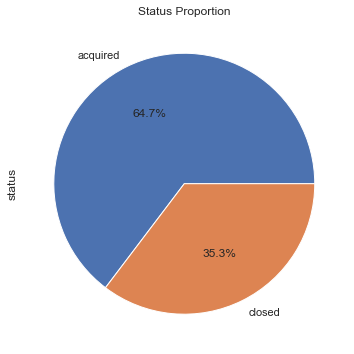

In [201]:
#Membuat pie chart dari data status
fig, ax1 = plt.subplots(1, 1, figsize=(8,6))
start_up['status'].value_counts(normalize=True).plot(ax=ax1, kind='pie',autopct="%.1f%%")
plt.title('Status Proportion')

## 2.5 Missing Values

Text(17.200000000000017, 0.5, 'Percentage Missing')

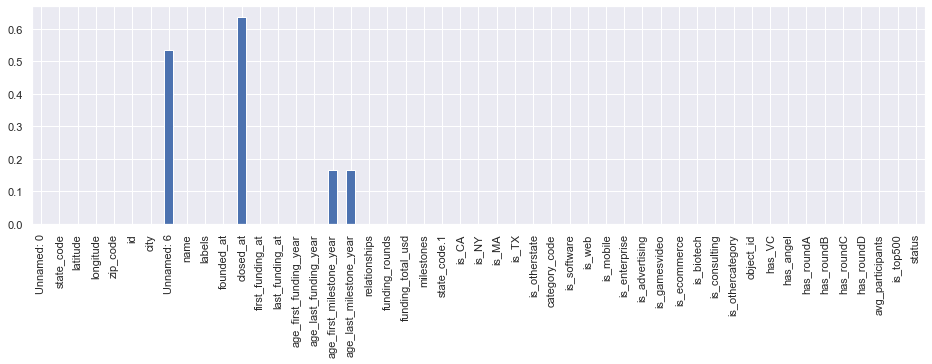

In [202]:
#Melihat presentase missing value dari semua kolom
fig, ax = plt.subplots(figsize=(16,4))

sns.color_palette("mako", as_cmap=True)
(start_up.isna().sum()/start_up.shape[0]).plot(kind='bar')
ax1.set_title('Missing Values: Train')
ax1.set_ylabel('Percentage Missing')

## 2.6 Outliers

In [203]:
to_box=['age_first_funding_year','age_last_funding_year',
            'age_first_milestone_year','age_last_milestone_year',
            'funding_total_usd']

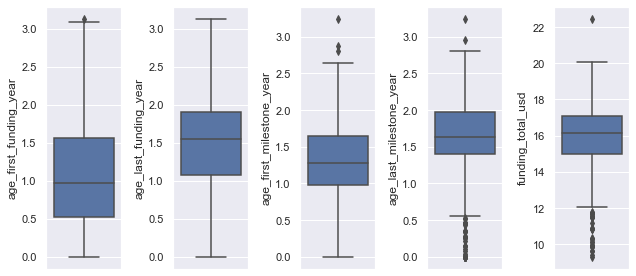

In [204]:
#Membuat box plot dari kolom-kolom terpilih
plt.figure(figsize=(9,4))
for i in range(0, len(to_box)):
    plt.subplot(1, len(to_box), i+1)
    sns.boxplot(y=start_up_pp[to_box[i]], orient='v')

plt.tight_layout()

# 3. Data Preprocessing

In [205]:
#Membuat duplicate dari data start_up untuk proses pre processing
start_up_pp = start_up.copy()

## 3.1 Encoding

In [169]:
#Melakukan encoding pada kolom status
start_up_pp['status'] = start_up_pp['status'].replace({'acquired': 1})
start_up_pp['status'] = start_up_pp['status'].replace({'closed': 0})

## 3.2 Rename Columns

In [171]:
#Melakukan penamaan ulang pada kolom status
start_up_pp.rename(columns={'status':'is_acquired'}, inplace=True)

## 3.3 Drop Unnecessary Columns

In [173]:
start_up_pp = start_up_pp.drop(['Unnamed: 0','Unnamed: 6','state_code',
                                'latitude','longitude','zip_code',
                                'id','city','name','labels','state_code.1',
                                'category_code','object_id','closed_at'], axis=1)

In [174]:
start_up_pp.shape

(923, 35)

## 3.4 Deal With Negative Values

In [175]:
#Menghapus baris yang terindikasi memiliki negative values
start_up_pp = start_up_pp.drop(start_up_pp[start_up_pp.age_first_funding_year<0].index)
start_up_pp = start_up_pp.drop(start_up_pp[start_up_pp.age_last_funding_year<0].index)
start_up_pp = start_up_pp.drop(start_up_pp[start_up_pp.age_first_milestone_year<0].index)
start_up_pp = start_up_pp.drop(start_up_pp[start_up_pp.age_first_milestone_year<0].index)

In [176]:
start_up_pp.shape

(840, 35)

## 3.5 Deal With Outliers

In [177]:
#Treat outlier dengan metode lognormal
start_up_pp["age_first_funding_year"] = np.log1p(start_up_pp["age_first_funding_year"])
start_up_pp["age_last_funding_year"] = np.log1p(start_up_pp["age_last_funding_year"])
start_up_pp["age_first_milestone_year"] = np.log1p(start_up_pp["age_first_milestone_year"])
start_up_pp["age_last_milestone_year"] = np.log1p(start_up_pp["age_last_milestone_year"])
start_up_pp["funding_total_usd"] = np.log1p(start_up_pp["funding_total_usd"])

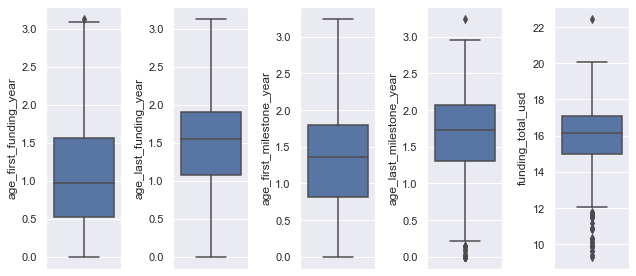

In [178]:
#Mengecek kembali box plot
plt.figure(figsize=(9,4))
for i in range(0, len(to_box)):
    plt.subplot(1, len(to_box), i+1)
    sns.boxplot(y=start_up_pp[to_box[i]], orient='v')

plt.tight_layout()

## 3.5 Deal With Missing Values

In [180]:
#Melakukan impute pada kolom dengan metode mean
age_first_milestone_imputer = SimpleImputer(strategy='median')
age_last_milestone_imputer = SimpleImputer(strategy='median')

In [181]:
start_up_pp['age_first_milestone_year'] = age_first_milestone_imputer.fit_transform(start_up_pp
                                                                                    ['age_first_milestone_year'].values.reshape(-1,1))
start_up_pp['age_last_milestone_year'] = age_last_milestone_imputer.fit_transform(start_up_pp
                                                                                    ['age_last_milestone_year'].values.reshape(-1,1))

In [182]:
start_up_pp.isnull().sum()

founded_at                  0
first_funding_at            0
last_funding_at             0
age_first_funding_year      0
age_last_funding_year       0
age_first_milestone_year    0
age_last_milestone_year     0
relationships               0
funding_rounds              0
funding_total_usd           0
milestones                  0
is_CA                       0
is_NY                       0
is_MA                       0
is_TX                       0
is_otherstate               0
is_software                 0
is_web                      0
is_mobile                   0
is_enterprise               0
is_advertising              0
is_gamesvideo               0
is_ecommerce                0
is_biotech                  0
is_consulting               0
is_othercategory            0
has_VC                      0
has_angel                   0
has_roundA                  0
has_roundB                  0
has_roundC                  0
has_roundD                  0
avg_participants            0
is_top500 

## 3.6 Add New Columns (Feature Engineering)

In [144]:
#Membuat kolom baru, jumlah bulan antara start up terbentuk hingga pertama kali menerima funding
start_up_pp['months_between_foundation_and_first_funding']=((start_up_pp.first_funding_at - start_up_pp.founded_at)/np.timedelta64(1, 'M'))

In [145]:
#Sudah diwakili dengan months_between_foundation_and_first_funding
start_up_pp = start_up_pp.drop(['founded_at','first_funding_at','last_funding_at'], axis=1)

In [148]:
#Membuat kolom baru, apakah start up ada pada tahap seed funding
start_up_pp['has_Seed'] = np.where((start_up_pp['age_first_funding_year'] == start_up_pp['age_last_funding_year']), 1, 0)

,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,is_CA,is_NY,...,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,is_acquired,months_between_foundation_and_first_funding,has_Seed
0,1.178440,1.386969,1.734925,2.041753,3,3,12.834684,3,1,0,...,1,0,0,0,0,1.0000,0,1,26.973860,0
1,1.812542,2.397650,2.080129,2.080129,9,4,17.506887,1,1,0,...,0,0,1,1,1,4.7500,1,1,61.471488,0
2,0.709463,0.709463,0.899145,1.164868,5,1,14.771022,2,1,0,...,0,1,0,0,0,4.0000,1,1,12.386291,1
3,1.418641,1.842944,1.946296,1.946296,5,3,17.504390,1,1,0,...,0,0,1,1,1,3.3333,1,1,37.553133,0
4,0.000000,0.981517,0.037681,0.037681,2,2,14.077876,1,1,0,...,1,0,0,0,0,1.0000,1,0,0.000000,0
5,1.712933,1.712933,1.792209,1.792209,3,1,15.830414,1,1,0,...,0,0,1,0,0,3.0000,1,0,54.506253,1
6,1.000816,1.826322,1.386294,2.029227,6,3,17.073607,2,1,0,...,0,1,1,0,0,1.6667,1,1,20.632867,0
7,0.973276,2.049188,1.887903,2.123650,25,3,17.344808,3,1,0,...,0,1,1,0,1,3.5000,1,1,19.745785,0
8,1.523074,2.494221,2.197836,2.397395,13,3,16.082469,4,0,0,...,0,1,0,0,1,4.0000,1,1,43.007043,0
9,0.982528,1.737814,1.365530,1.962219,14,3,15.564711,4,1,0,...,1,1,0,0,0,1.0000,1,1,20.041479,0


In [149]:
#Sudah diwakili dengan has_seed
start_up_pp = start_up_pp.drop(['age_first_funding_year','age_last_funding_year'], axis=1)

## 3.7 Remaining Outliers

In [ ]:
Q1 = np.percentile(start_up_pp['funding_total_usd'], 25, 
                   interpolation = 'midpoint') 
  
Q3 = np.percentile(start_up_pp['funding_total_usd'], 75,
                   interpolation = 'midpoint') 
IQR = Q3 - Q1 
  
print("Old Shape: ", start_up_pp.shape) 
  
# Upper bound
upper = np.where(start_up_pp['funding_total_usd'] >= (Q3+1.5*IQR))
# Lower bound
lower = np.where(start_up_pp['funding_total_usd'] <= (Q1-1.5*IQR))
  
''' Removing the Outliers '''
start_up_pp.drop(upper[0],inplace = True, axis=0)
start_up_pp.drop(lower[0],inplace = True, axis=0)
print("New Shape: ", start_up_pp.shape)
Q1

# 4. Modelling & Evaluation

In [150]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

## 4.1 Split Data

In [151]:
#Melakukan split data train dan data test
train_x, test_x, train_y, test_y = train_test_split(start_up_pp.drop(columns='is_acquired'), start_up_pp['is_acquired'], test_size=0.2, random_state=134)

## 4.2 Modelling

In [152]:
#Logistic Regression

lg = LogisticRegression()
lg.fit(train_x, train_y)
pred_lg = lg.predict(test_x)

print('Classification report model')
print(classification_report(test_y, pred_lg, digits=5))

Classification report model
              precision    recall  f1-score   support

           0    0.60000   0.55102   0.57447        49
           1    0.82114   0.84874   0.83471       119

    accuracy                        0.76190       168
   macro avg    0.71057   0.69988   0.70459       168
weighted avg    0.75664   0.76190   0.75881       168



In [153]:
# XGBoost

from xgboost import XGBClassifier

xgbcl = XGBClassifier()
xgbcl.fit(train_x,train_y)
pred_xg = xgbcl.predict(test_x)

print('Classification report model')
print(classification_report(test_y, pred_xg, digits=5))

[01:50:15] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Classification report model
              precision    recall  f1-score   support

           0    0.68889   0.63265   0.65957        49
           1    0.85366   0.88235   0.86777       119

    accuracy                        0.80952       168
   macro avg    0.77127   0.75750   0.76367       168
weighted avg    0.80560   0.80952   0.80705       168



In [154]:
#Decision Tree

dt = DecisionTreeClassifier(random_state=777)
dt.fit(train_x, train_y)
pred_dt = dt.predict(test_x)

print('Classification report model')
print(classification_report(test_y, pred_dt, digits=5))

Classification report model
              precision    recall  f1-score   support

           0    0.45614   0.53061   0.49057        49
           1    0.79279   0.73950   0.76522       119

    accuracy                        0.67857       168
   macro avg    0.62447   0.63505   0.62789       168
weighted avg    0.69460   0.67857   0.68511       168



In [155]:
# Support Vector Classifier

svc = SVC(random_state=69)
svc.fit(train_x, train_y)
pred_svc = svc.predict(test_x)

print('Classification report model')
print(classification_report(test_y, pred_svc, digits=5))

Classification report model
              precision    recall  f1-score   support

           0    0.82353   0.28571   0.42424        49
           1    0.76821   0.97479   0.85926       119

    accuracy                        0.77381       168
   macro avg    0.79587   0.63025   0.64175       168
weighted avg    0.78435   0.77381   0.73238       168



In [156]:
#Random Forest

rf = RandomForestClassifier(random_state=69)
rf.fit(train_x, train_y)
pred_rf = rf.predict(test_x)

print('Classification report model')
print(classification_report(test_y, pred_rf, digits=5))

#paling tinggi

Classification report model
              precision    recall  f1-score   support

           0    0.75676   0.57143   0.65116        49
           1    0.83969   0.92437   0.88000       119

    accuracy                        0.82143       168
   macro avg    0.79823   0.74790   0.76558       168
weighted avg    0.81550   0.82143   0.81326       168



In [157]:
#Light gbm

import lightgbm as lgb

clf = lgb.LGBMClassifier()
clf.fit(train_x, train_y)
pred_lgb = clf.predict(test_x)

print('Classification report model')
print(classification_report(test_y, pred_lgb, digits=5))

Classification report model
              precision    recall  f1-score   support

           0    0.66667   0.53061   0.59091        49
           1    0.82171   0.89076   0.85484       119

    accuracy                        0.78571       168
   macro avg    0.74419   0.71068   0.72287       168
weighted avg    0.77649   0.78571   0.77786       168



## 4.3 Feature Importance

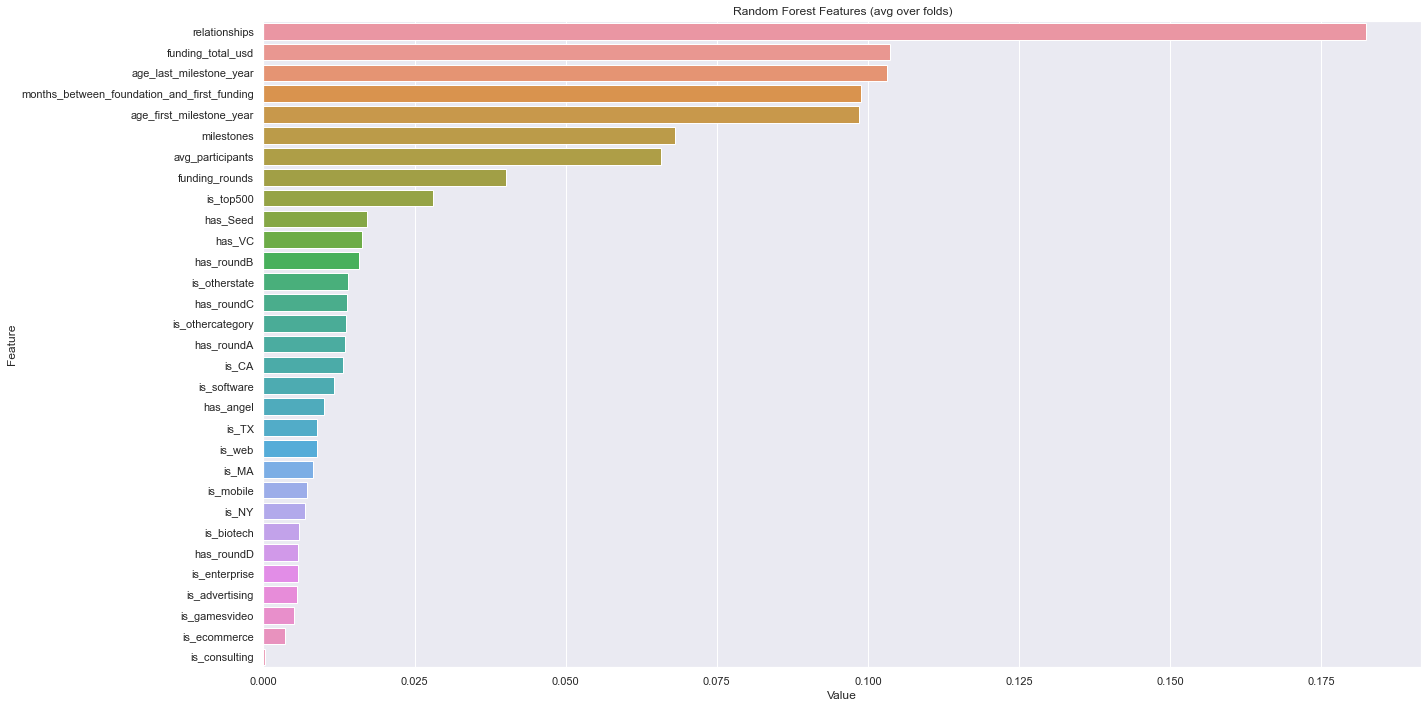

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(rf.feature_importances_,train_x.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Random Forest Features (avg over folds)')
plt.tight_layout()
plt.show()

## 4.4 ROC Graph

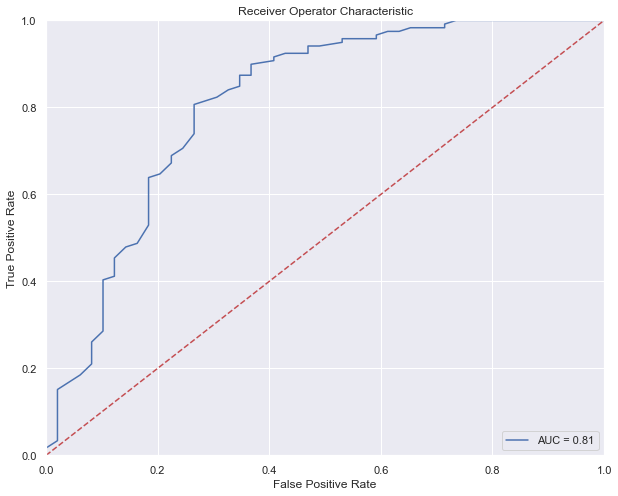

In [103]:
PredictProb = rf.predict_proba(test_x)
preds = PredictProb[:,1]
fpr, tpr, threshold = roc_curve(test_y, preds)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10,8))
plt.title('Receiver Operator Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = {}'.format(round(roc_auc, 2)))
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 4.5 Confusion Matrix

In [104]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_y, pred_rf) 

array([[ 28,  21],
       [  9, 110]], dtype=int64)

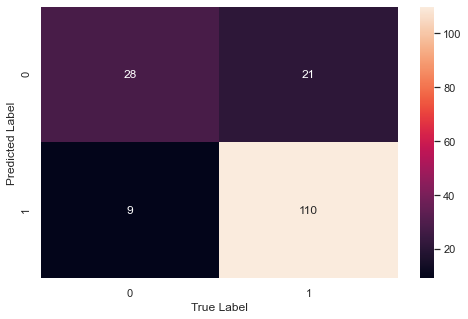

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(test_y,pred_rf), annot=True, fmt=".0f", ax=ax)
plt.xlabel("True Label")
plt.ylabel("Predicted Label")
plt.show()